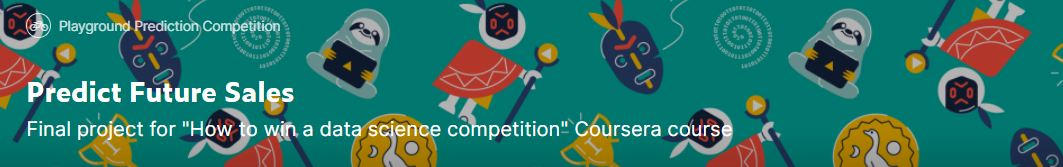

This kernel is going to solve <font color="red"><b> Predict Future Sales with Advanced Regression Analysis</b></font>, a popular machine learning dataset for <b>Kaggler</b>.<br> 
I am going to share how I work with a dataset step by step  <b>from data preparation and data analysis to statistical tests and implementing machine learning models.</b> <br>
I will also describe the model results along with other tips.<br>
Let's get started.</div>
<br>
If you like this notebook or find this notebook helpful, Please feel free to <font color="red"><b>UPVOTE</b></font> and/or leave a comment.
 
<div> <b>This notebook is always a work in progress. So, please stay tuned for more to come.</b></div>


This notebook referenced the following.<br>
https://www.kaggle.com/deinforcement/top-1-predict-future-sales-features-lightgbm<br>
https://www.kaggle.com/werooring/top-3-5-lightgbm-with-feature-engineering<br>
https://www.kaggle.com/dlarionov/feature-engineering-xgboost

# 1: Importing Necessary Libraries and datasets

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

import seaborn as sns
import sys
import itertools
import gc

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

import csv
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import datetime

In [56]:
cats = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
shops = pd.read_csv('data/shops.csv')

# 2. Data Preprocessing

In [57]:
# Change data type for date calculation
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")
# Merge some duplicate shops
# train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
# Keep only shops that are in the test set
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]
# Drop training items with extreme or negative prices or sales counts
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

In [58]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])

In [59]:
# Create the date the product was first sold as a feature
items['first_sale_date'] = train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
# Refine null values in items table
items = items.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

In [60]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

In [61]:
# Merge data
train = train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(cats, on='item_category_id', how='left')
test = test.merge(shops, on='shop_id', how='left')
test = test.merge(items, on='item_id', how='left')
test = test.merge(cats, on='item_category_id', how='left')

In [62]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)
test = test.drop(columns="ID")

In [63]:
df = pd.concat([train, test])

In [64]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = df.merge(group, on=['date_block_num','shop_id','item_id'], how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

df = df.drop(['date','shop_name','item_name','item_cnt_day'], axis=1)

In [65]:
def add_mean(df, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    
    return df

In [66]:
# Create monthly average sales derived features grouped by ['date_block_num', 'item_id']
df = add_mean(df=df, idx_features=['date_block_num', 'item_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id']
df = add_mean(df=df, idx_features=['date_block_num', 'shop_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_category_id']
df = add_mean(df=df, idx_features=['date_block_num', 'item_category_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id', 'city']
df = add_mean(df=df, idx_features=['date_block_num', 'item_id', 'city'])

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'item_category_id']
df = add_mean(df=df, idx_features=['date_block_num', 'shop_id', 'item_category_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'subtype_code']
df = add_mean(df=df, idx_features=['date_block_num', 'shop_id', 'subtype_code'])

In [54]:
df.sort_values(['item_id', 'shop_id', 'date_block_num'])

,date_block_num,shop_id,item_id,item_price,city,item_category_id,first_sale_date,type_code,subtype_code,item_cnt_month,item_id_mean_sales,shop_id_mean_sales,item_category_id_mean_sales,item_id_city_mean_sales,shop_id_item_category_id_mean_sales,shop_id_subtype_code_mean_sales
1223183,15,55,1,4490.0,27,76,15.0,15,31,2.0,2.0,6.859375,7.015625,2.0,7.015625,7.015625
1223238,15,55,1,4490.0,27,76,15.0,15,31,2.0,2.0,6.859375,7.015625,2.0,7.015625,7.015625
1435939,18,55,1,4490.0,27,76,15.0,15,31,1.0,1.0,7.335938,7.160156,1.0,7.160156,7.160156
1513679,19,55,1,4490.0,27,76,15.0,15,31,1.0,1.0,8.218750,8.085938,1.0,8.085938,8.085938
1605383,20,55,1,4490.0,27,76,15.0,15,31,1.0,1.0,8.164062,8.179688,1.0,8.179688,8.179688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41637,0,12,22168,799.0,7,62,0.0,14,28,1.0,1.0,4.074219,2.955078,1.0,2.199219,2.199219
689918,8,12,22168,799.0,7,62,0.0,14,28,1.0,1.0,6.914062,2.476562,1.0,1.000000,1.000000
97744,1,16,22168,799.0,10,62,0.0,14,28,1.0,1.0,3.427734,2.683594,1.0,2.626953,2.626953
90056,1,42,22168,799.0,19,62,0.0,14,28,1.0,1.0,5.164062,2.683594,1.0,3.208984,3.208984


In [68]:
# 
df['duration_after_first_sale'] = df['date_block_num'] - df['first_sale_date']

# month of the year
df['month'] = df['date_block_num']%12

In [75]:
# keep_from_month = 2  # The first couple of months are dropped because of distortions to their features (e.g. wrong item age)
valid_month = 33

valid = df.loc[df.date_block_num == valid_month, :]
train = df.loc[df.date_block_num < valid_month, :]
# train = train[train.date_block_num >= keep_from_month]
X_train = train.drop(columns="item_cnt_month")
y_train = train.item_cnt_month
X_valid = valid.drop(columns="item_cnt_month")
y_valid = valid.item_cnt_month
test = df.drop(columns="item_cnt_month").loc[df.date_block_num == 34, :]

In [76]:
model_lgb = LGBMRegressor(colsample_bytree=0.8,learning_rate=0.01, max_depth=8,
              min_child_weight=1, min_split_gain=0.0222415, n_estimators=35000,
              num_leaves=966, reg_alpha=0.04, reg_lambda=0.073,
              subsample=0.6)

In [77]:
start = datetime.datetime.now()
lgbm = model_lgb.fit(X_train, 
                     y_train,
                     eval_set = [(X_train, y_train), (X_valid, y_valid)],
                     eval_metric ='rmse',
                     early_stopping_rounds = 400,
                     verbose =True)
end = datetime.datetime.now()
end-start

[1]	training's rmse: 5.29721	training's l2: 28.0604	valid_1's rmse: 5.03232	valid_1's l2: 25.3242
[2]	training's rmse: 5.24764	training's l2: 27.5377	valid_1's rmse: 4.9855	valid_1's l2: 24.8552
[3]	training's rmse: 5.19846	training's l2: 27.024	valid_1's rmse: 4.93862	valid_1's l2: 24.39
[4]	training's rmse: 5.14991	training's l2: 26.5216	valid_1's rmse: 4.89279	valid_1's l2: 23.9394
[5]	training's rmse: 5.10709	training's l2: 26.0823	valid_1's rmse: 4.85264	valid_1's l2: 23.5481
[6]	training's rmse: 5.05961	training's l2: 25.5996	valid_1's rmse: 4.80824	valid_1's l2: 23.1191
[7]	training's rmse: 5.01262	training's l2: 25.1263	valid_1's rmse: 4.7637	valid_1's l2: 22.6928
[8]	training's rmse: 4.96596	training's l2: 24.6608	valid_1's rmse: 4.7196	valid_1's l2: 22.2747
[9]	training's rmse: 4.91984	training's l2: 24.2048	valid_1's rmse: 4.67607	valid_1's l2: 21.8656
[10]	training's rmse: 4.87429	training's l2: 23.7587	valid_1's rmse: 4.63293	valid_1's l2: 21.4641
[11]	training's rmse: 4.8

datetime.timedelta(seconds=498, microseconds=684707)

In [80]:
feature_imp

,Value,Feature
0,184122,item_id_city_mean_sales
1,124402,shop_id_item_category_id_mean_sales
2,121778,item_id_mean_sales
3,113986,shop_id
4,108429,shop_id_mean_sales
5,77829,shop_id_subtype_code_mean_sales
6,76257,item_category_id_mean_sales
7,71730,item_id
8,58144,item_price
9,36230,duration_after_first_sale


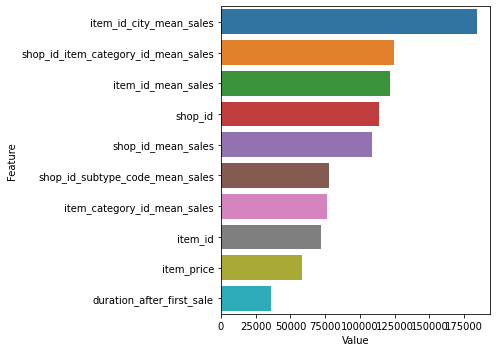

In [78]:
feature_imp= pd.DataFrame(sorted(zip(lgbm.feature_importances_, X_train.columns), reverse = True), columns = ['Value', 'Feature'])
# feature_imp.to_excel("feature_imp.xlsx")

plt.figure(figsize=(7,5))
sns.barplot(x='Value', y='Feature', data=feature_imp[:10].sort_values(by='Value', ascending=False))
plt.tight_layout()
plt.show()
plt.savefig('lightGBM_ Importances.png')

# 3. Modeling

In [81]:
sales_prediction = model_lgb.predict(test)
test = pd.read_csv("data/test.csv")
test_result= pd.DataFrame(sales_prediction)
test_result.columns = ['item_cnt_month']
predict = test_result['item_cnt_month']
sales_predict_submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':predict})
sales_predict_submission.to_csv('submission.csv', index=False)